# Summary of this file

This file presents a comparison of various machine learning algorithms fitted to different combinations of modalities for two main purposes:

1. To observe the performance between CatBoost and LGBM.
2. To examine how the performance varies within the same models when using different modalities.

NOTE:
For categorical features, since we have already attempted one-hot encoding with these two top-performing models, and these two models have built-in support for handling categorical variables directly, we can simply use categorical encoding.

Results:
1. Including more modalities definitely leads to improved performance.

In [51]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import classification_report, accuracy_score
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
from functools import partial
import scipy as sp
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import KFold
from joblib import dump
import re

import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import catboost
import optuna
import joblib
import shap
import pickle

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import cohen_kappa_score

In [52]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    def coefficients(self):
        return self.coef_['x']

In [53]:
# df = pd.read_csv(f'petfinder-adoption-prediction/train/train.csv')
# X = df.drop(columns=['AdoptionSpeed'])
# y = df['AdoptionSpeed']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# df['iftrain'] = 0
# df.loc[df.index.isin(X_train.index), 'iftrain'] = 1
# df.to_csv(f'petfinder-adoption-prediction/train/train_split.csv')

In [54]:
df = pd.read_csv(f'petfinder-adoption-prediction/train/train_split.csv')
df_test = pd.read_csv(f'petfinder-adoption-prediction/test/test.csv')

In [91]:
non_numeric_columns = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'State']

def Split(
    df_in, bert=True, beit=True, breed=True, txt=True, meta=True, senti=True, newcols=True,
    pca_bert=200, pca_breed=200
):
    # get normal files
    df = df_in.copy(deep=True) 
    name = 'train'
    # extra modals
    if beit:
        beit_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/beit_emb.csv')
        beit_emb = beit_emb.drop(columns=['Description', 'PhotoAmt'])
        df = pd.merge(df, beit_emb, on=['PetID'], how='left')
    if bert and pca_bert > 0: 
        bert_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/bert_pca200_ALL.csv') # 100 enough
        bert_emb = bert_pca200_ALL[['PetID'] + [f'bert_pc_{i}' for i in range(1, pca_bert + 1)]] # PetID
        df = pd.merge(df, bert_emb, on=['PetID'], how='left')
    if breed and pca_breed > 0: 
        breed_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/breed_pca200_ALL.csv') # 100 enough
        breed_emb = breed_pca200_ALL[['BreedID'] + [f'breed_pc_{i}' for i in range(1, pca_breed + 1)]] # BreedID
        df = pd.merge(df, breed_emb, left_on=['Breed1'], right_on=['BreedID'], how='left')
        df = df.drop(columns=['BreedID'])  
    if txt: 
        txt_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/txt_emb.csv').drop(columns=['Description', 'PhotoAmt'])
        df = pd.merge(df, txt_emb, on=['PetID'], how='left')
    if meta: 
        metadata_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/metadata_gr.csv')
        df = pd.merge(df, metadata_gr, on=['PetID'], how='left')
    if senti: 
        sentiment_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/sentiment_gr.csv')
        df = pd.merge(df, sentiment_gr, on=['PetID'], how='left')
    if newcols: 
        new_cols_ALL = pd.read_csv('petfinder-adoption-prediction/train/new_cols_ALL.csv') # PetID
        df = pd.merge(df, new_cols_ALL, on=['PetID'], how='left')
    # catagorical one-hot encoding
    for col in non_numeric_columns: 
        df[non_numeric_columns] = df[non_numeric_columns].astype('category')
    df_encoded = df
    # make sure feature names are valid
    df_encoded = df_encoded.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # split into train & test
    to_drop = ['AdoptionSpeed', 'Name', 'Description', 'PetID', 'RescuerID', 'iftrain']
    X = df_encoded.drop(columns=to_drop)
    Y = df_encoded['AdoptionSpeed']
    # return results
    return X, Y

In [55]:
non_numeric_columns = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'State']

def PreProcess(
    df_in, bert=True, beit=True, breed=True, txt=True, meta=True, senti=True, newcols=True,
    pca_bert=200, pca_breed=200
):
    # get normal files
    df = df_in.copy(deep=True) 
    name = 'train'
    # extra modals
    if beit:
        beit_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/beit_emb.csv')
        beit_emb = beit_emb.drop(columns=['Description', 'PhotoAmt'])
        df = pd.merge(df, beit_emb, on=['PetID'], how='left')
    if bert and pca_bert > 0: 
        bert_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/bert_pca200_ALL.csv') # 100 enough
        bert_emb = bert_pca200_ALL[['PetID'] + [f'bert_pc_{i}' for i in range(1, pca_bert + 1)]] # PetID
        df = pd.merge(df, bert_emb, on=['PetID'], how='left')
    if breed and pca_breed > 0: 
        breed_pca200_ALL = pd.read_csv('petfinder-adoption-prediction/train/breed_pca200_ALL.csv') # 100 enough
        breed_emb = breed_pca200_ALL[['BreedID'] + [f'breed_pc_{i}' for i in range(1, pca_breed + 1)]] # BreedID
        df = pd.merge(df, breed_emb, left_on=['Breed1'], right_on=['BreedID'], how='left')
        df = df.drop(columns=['BreedID'])  
    if txt: 
        txt_emb = pd.read_csv(f'petfinder-adoption-prediction/{name}/txt_emb.csv').drop(columns=['Description', 'PhotoAmt'])
        df = pd.merge(df, txt_emb, on=['PetID'], how='left')
    if meta: 
        metadata_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/metadata_gr.csv')
        df = pd.merge(df, metadata_gr, on=['PetID'], how='left')
    if senti: 
        sentiment_gr = pd.read_csv(f'petfinder-adoption-prediction/{name}/sentiment_gr.csv')
        df = pd.merge(df, sentiment_gr, on=['PetID'], how='left')
    if newcols: 
        new_cols_ALL = pd.read_csv('petfinder-adoption-prediction/train/new_cols_ALL.csv') # PetID
        df = pd.merge(df, new_cols_ALL, on=['PetID'], how='left')
    # catagorical one-hot encoding
    for col in non_numeric_columns: 
        df[non_numeric_columns] = df[non_numeric_columns].astype('category')
    df_encoded = df
    # make sure feature names are valid
    df_encoded = df_encoded.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # split into train & test
    train_df, test_df = df_encoded[df_encoded['iftrain'] == 1], df_encoded[df_encoded['iftrain'] == 0]
    to_drop = ['AdoptionSpeed', 'Name', 'Description', 'PetID', 'RescuerID', 'iftrain']
    X_train = train_df.drop(columns=to_drop)
    Y_train = train_df['AdoptionSpeed']
    X_test = test_df.drop(columns=to_drop)
    Y_test = test_df['AdoptionSpeed']
    # return results
    return X_train, X_test, Y_train, Y_test

In [57]:
import pandas as pd

def quick_check_regression(X_train, X_test, y_train, y_test):
    models = {
        "LGBM Regressor": LGBMRegressor(verbose=0, n_jobs=-1, categorical_feature=non_numeric_columns),
        "CatBoost Regressor": CatBoostRegressor(verbose=0, thread_count=-1, cat_features=non_numeric_columns)  
    }

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame(columns=["Model", "Cohen's Kappa Score"])

    for name, model in models.items():
        # print(f"\n\n=========={name}==========")
        model.fit(X_train, y_train)
        preds = model.predict(X_train)
        optR = OptimizedRounder()
        optR.fit(preds, y_train.values)
        coefficients = optR.coefficients()
        pred_y = optR.predict(model.predict(X_test), coefficients)
        kappa_score = cohen_kappa_score(y_test, pred_y, weights='quadratic')
        # print(f"Testing Cohen's Kappa Score : {kappa_score}")
        result = pd.DataFrame([[name, kappa_score]], columns=["Model", "Cohen's Kappa Score"])
        results_df = pd.concat([results_df, result], ignore_index=True)
    return results_df

## basic

In [58]:
# basic
bert=False
beit=False
breed=False
txt=False
meta=False
senti=False
newcols=False
pca_bert=0
pca_breed=0
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.366827
1,CatBoost Regressor,0.371970


In [59]:
# basic + bert
bert=True
beit=False
breed=False
txt=False
meta=False
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.364867
1,CatBoost Regressor,0.374952


In [60]:
# basic + bert + breed
bert=True
beit=False
breed=True
txt=False
meta=False
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.376745
1,CatBoost Regressor,0.382212


In [61]:
# basic + beit
bert=False
beit=True
breed=False
txt=False
meta=False
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.388044
1,CatBoost Regressor,0.390247


In [62]:
# basic + senti
bert=False
beit=False
breed=False
txt=False
meta=False
senti=True
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.368303
1,CatBoost Regressor,0.362618


In [63]:
# basic + meta
bert=False
beit=False
breed=False
txt=False
meta=True
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.365261
1,CatBoost Regressor,0.367350


In [64]:
# basic + meta + senti
bert=False
beit=False
breed=False
txt=False
meta=True
senti=True
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.357666
1,CatBoost Regressor,0.361032


In [65]:
# basic + bert + breed + beit
bert=True
beit=True
breed=True
txt=False
meta=False
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.415616
1,CatBoost Regressor,0.418694


In [66]:
# basic + txt
bert=False
beit=False
breed=False
txt=True
meta=False
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.375392
1,CatBoost Regressor,0.362386


In [67]:
# basic + meta + senti + txt
bert=False
beit=False
breed=False
txt=True
meta=True
senti=True
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.371684
1,CatBoost Regressor,0.366876


In [68]:
# basic + bert + breed + beit + meta + senti + txt
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.405032
1,CatBoost Regressor,0.406217


In [69]:
# basic + meta + txt
bert=False
beit=False
breed=False
txt=True
meta=True
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.360156
1,CatBoost Regressor,0.352124


In [70]:
# basic + bert + breed + beit + meta + txt
bert=True
beit=True
breed=True
txt=True
meta=True
senti=False
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.409855
1,CatBoost Regressor,0.412510


In [151]:
# basic + senti + txt
bert=False
beit=False
breed=False
txt=True
meta=False
senti=True
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.377743
1,CatBoost Regressor,0.378388


In [152]:
# basic + bert + breed + meta + senti + txt
bert=True
beit=False
breed=True
txt=True
meta=True
senti=True
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.367796
1,CatBoost Regressor,0.376578


In [153]:
# basic + beit + meta + senti + txt
bert=False
beit=True
breed=False
txt=True
meta=True
senti=True
newcols=False
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.410855
1,CatBoost Regressor,0.394259


## advanced (always have newcols)

In [71]:
# advanced
bert=False
beit=False
breed=False
txt=False
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.406922
1,CatBoost Regressor,0.404311


In [72]:
# advanced + bert
bert=True
beit=False
breed=False
txt=False
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.413553
1,CatBoost Regressor,0.407842


In [73]:
# advanced + bert + breed
bert=True
beit=False
breed=True
txt=False
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.396696
1,CatBoost Regressor,0.395192


In [74]:
# advanced + beit
bert=False
beit=True
breed=False
txt=False
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.422636
1,CatBoost Regressor,0.429826


In [75]:
# advanced + senti
bert=False
beit=False
breed=False
txt=False
meta=False
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.402215
1,CatBoost Regressor,0.411624


In [76]:
# advanced + meta
bert=False
beit=False
breed=False
txt=False
meta=True
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.384582
1,CatBoost Regressor,0.387458


In [77]:
# advanced + meta + senti
bert=False
beit=False
breed=False
txt=False
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.395401
1,CatBoost Regressor,0.396109


In [78]:
# advanced + bert + breed + beit
bert=True
beit=True
breed=True
txt=False
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.427444
1,CatBoost Regressor,0.437551


In [79]:
# advanced + txt
bert=False
beit=False
breed=False
txt=True
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.402540
1,CatBoost Regressor,0.395628


In [80]:
# advanced + meta + senti + txt
bert=False
beit=False
breed=False
txt=True
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.390298
1,CatBoost Regressor,0.389988


In [81]:
# advanced + bert + breed + beit + meta + senti + txt (200)
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.42785
1,CatBoost Regressor,0.43121


In [82]:
# advanced + meta + txt
bert=False
beit=False
breed=False
txt=True
meta=True
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.399345
1,CatBoost Regressor,0.384126


In [83]:
# advanced + bert + breed + beit + meta + txt
bert=True
beit=True
breed=True
txt=True
meta=True
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.429146
1,CatBoost Regressor,0.441144


In [84]:
# advanced + bert + breed + beit + meta + senti + txt (100)
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=100
pca_breed=100
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.429301
1,CatBoost Regressor,0.426544


In [85]:
# advanced + bert + beit + meta + senti + txt (200)
bert=True
beit=True
breed=False
txt=True
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.430136
1,CatBoost Regressor,0.424917


In [86]:
# advanced + bert + breed + beit + meta + senti + txt (150)
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=150
pca_breed=150
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.419004
1,CatBoost Regressor,0.436655


In [87]:
# advanced + bert + breed + beit + meta + senti + txt (160)
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=160
pca_breed=160
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.418836
1,CatBoost Regressor,0.430335


In [88]:
# advanced + bert + breed + beit + meta + senti + txt (170)
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=170
pca_breed=170
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.429097
1,CatBoost Regressor,0.440728


In [89]:
# advanced + bert + breed + beit + meta + senti + txt (180)
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=180
pca_breed=180
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.413942
1,CatBoost Regressor,0.436146


In [90]:
# advanced + bert + breed + beit + meta + senti + txt (190)
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=190
pca_breed=190
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.424012
1,CatBoost Regressor,0.431512


In [154]:
# advanced + senti + txt
bert=False
beit=False
breed=False
txt=True
meta=False
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.403422
1,CatBoost Regressor,0.396336


In [155]:
# advanced + bert + breed + meta + senti + txt
bert=True
beit=False
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.400165
1,CatBoost Regressor,0.407927


In [156]:
# advanced + beit + meta + senti + txt
bert=False
beit=True
breed=False
txt=True
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.433317
1,CatBoost Regressor,0.422608


In [157]:
# advanced + bert + beit
bert=True
beit=True
breed=False
txt=False
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.436703
1,CatBoost Regressor,0.432402


## final compare

In [158]:
# advanced + T200 G s
bert=True
beit=True
breed=False
txt=False
meta=False
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.419741
1,CatBoost Regressor,0.441630


In [159]:
# advanced + T200 b200 G s
bert=True
beit=True
breed=True
txt=False
meta=False
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.433364
1,CatBoost Regressor,0.441839


In [160]:
# advanced + T200 G t
bert=True
beit=True
breed=False
txt=True
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.418410
1,CatBoost Regressor,0.443546


In [161]:
# advanced + T200 b200 G t
bert=True
beit=True
breed=True
txt=True
meta=False
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.420966
1,CatBoost Regressor,0.434905


In [162]:
# advanced + T200 G m t
bert=True
beit=True
breed=False
txt=True
meta=True
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.417965
1,CatBoost Regressor,0.443119


In [163]:
# advanced + T200 b200 G m t
bert=True
beit=True
breed=True
txt=True
meta=True
senti=False
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.429146
1,CatBoost Regressor,0.441144


In [164]:
# advanced + T200 G m s t
bert=True
beit=True
breed=False
txt=True
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X_train, X_test, y_train, y_test = PreProcess(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
result = quick_check_regression(X_train, X_test, y_train, y_test)
result

[LightGBM] [Warning] categorical_feature is set=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State, categorical_column=2,4,5,6,7,8,9,18 will be ignored. Current value: categorical_feature=Type,Breed1,Breed2,Gender,Color1,Color2,Color3,State


,Model,Cohen's Kappa Score
0,LGBM Regressor,0.430136
1,CatBoost Regressor,0.424917


In [93]:
bert=True
beit=True
breed=True
txt=True
meta=True
senti=True
newcols=True
pca_bert=200
pca_breed=200
X, Y = Split(
    df, bert, beit, breed, txt, meta, senti, newcols, pca_bert, pca_breed
)
model = CatBoostRegressor(verbose=0, thread_count=-1, cat_features=non_numeric_columns)  
model.fit(X, Y)
preds = model.predict(X)
optR = OptimizedRounder()
optR.fit(preds, Y.values)
coefficients = optR.coefficients()
pred_y = optR.predict(model.predict(X), coefficients)
kappa_score = cohen_kappa_score(Y, pred_y, weights='quadratic')
print(f"Testing Cohen's Kappa Score : {kappa_score}")

Testing Cohen's Kappa Score : 0.8863427153167841


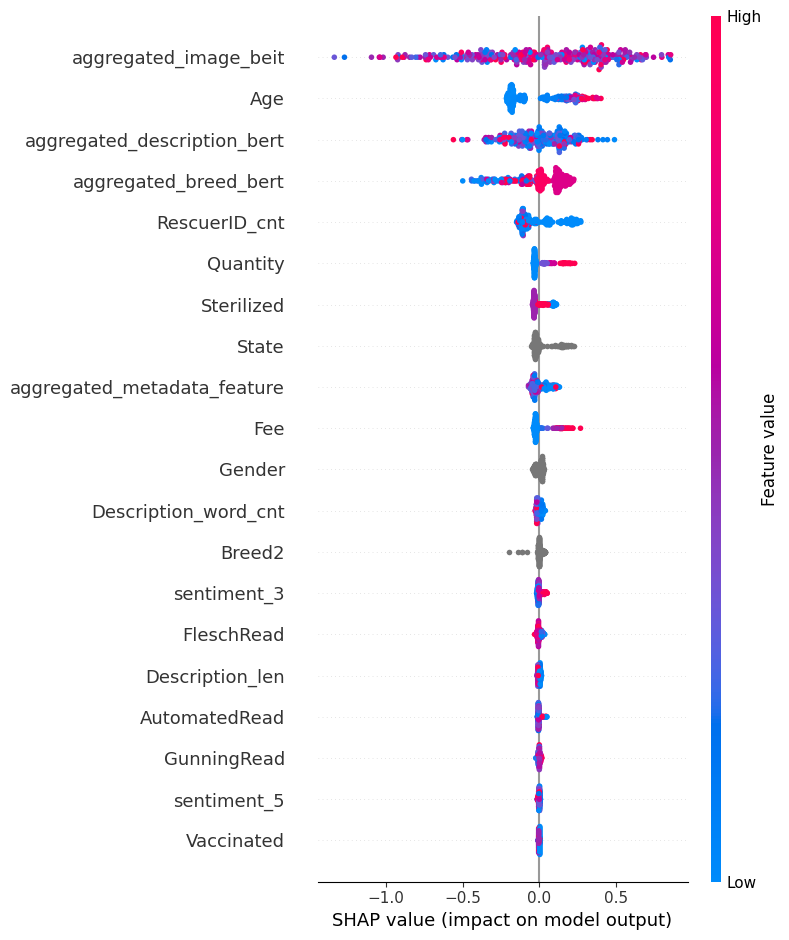

In [166]:
X_sample, _, y_sample, _ = train_test_split(X, Y, stratify=Y, test_size=0.98, random_state=42)
explainer_cat = shap.TreeExplainer(model)
shap_values_cat = explainer_cat.shap_values(X_sample)

# Define new feature sets
beit_features = [f'beit_{i}' for i in range(1, 769)]
bert_features = [f'bert_pc_{i}' for i in range(1, 201)]
breed_features = [f'breed_pc_{i}' for i in range(1, 201)]
metadata_features = [col for col in X_sample.columns if "metadata" in col]

# Find indices for these features
beit_indices = [X_sample.columns.get_loc(feature) for feature in beit_features]
bert_indices = [X_sample.columns.get_loc(feature) for feature in bert_features]
breed_indices = [X_sample.columns.get_loc(feature) for feature in breed_features]
metadata_indices = [X_sample.columns.get_loc(feature) for feature in metadata_features]

# Aggregate SHAP values for the new feature sets
image_shap_values = shap_values_cat[:, range(beit_indices[0], beit_indices[-1]+1)].sum(axis=1)
bert_shap_values = shap_values_cat[:, range(bert_indices[0], bert_indices[-1]+1)].sum(axis=1)
breed_shap_values = shap_values_cat[:, range(breed_indices[0], breed_indices[-1]+1)].sum(axis=1)
metadata_shap_values = np.sum([shap_values_cat[:, idx] for idx in metadata_indices], axis=0)

# Adjust X_sample
X_sample_adjusted = X_sample.drop(columns=beit_features + bert_features + breed_features + metadata_features)
X_sample_adjusted['aggregated_image_beit'] = X_sample[beit_features].mean(axis=1)
X_sample_adjusted['aggregated_description_bert'] = X_sample[bert_features].mean(axis=1)
X_sample_adjusted['aggregated_breed_bert'] = X_sample[breed_features].mean(axis=1)
X_sample_adjusted['aggregated_metadata_feature'] = X_sample[metadata_features].mean(axis=1)

# Adjust the SHAP values matrix
shap_values_adjusted = np.delete(shap_values_cat, beit_indices + bert_indices + breed_indices + metadata_indices, axis=1)
shap_values_adjusted = np.insert(shap_values_adjusted, X_sample_adjusted.columns.get_loc('aggregated_image_beit'), image_shap_values, axis=1)
shap_values_adjusted = np.insert(shap_values_adjusted, X_sample_adjusted.columns.get_loc('aggregated_description_bert'), bert_shap_values, axis=1)
shap_values_adjusted = np.insert(shap_values_adjusted, X_sample_adjusted.columns.get_loc('aggregated_breed_bert'), breed_shap_values, axis=1)
shap_values_adjusted = np.insert(shap_values_adjusted, X_sample_adjusted.columns.get_loc('aggregated_metadata_feature'), metadata_shap_values, axis=1)

# Use the adjusted SHAP values and dataset for the summary plot
shap.summary_plot(shap_values_adjusted, X_sample_adjusted)

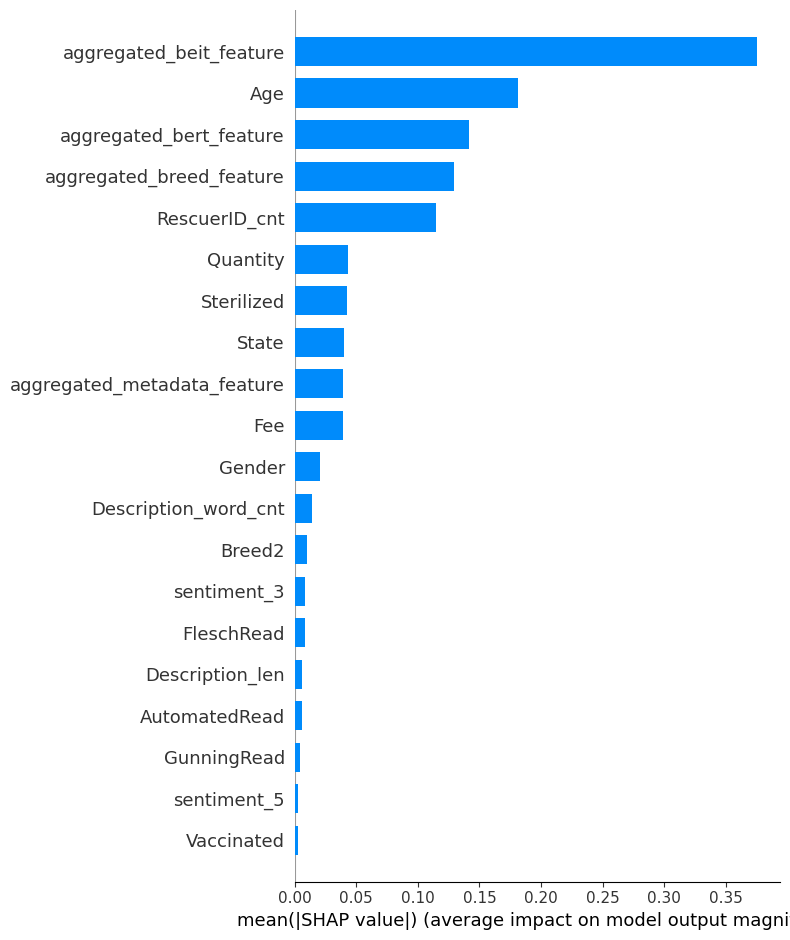

In [150]:
shap.summary_plot(shap_values_adjusted, X_sample_adjusted, plot_type='bar') 

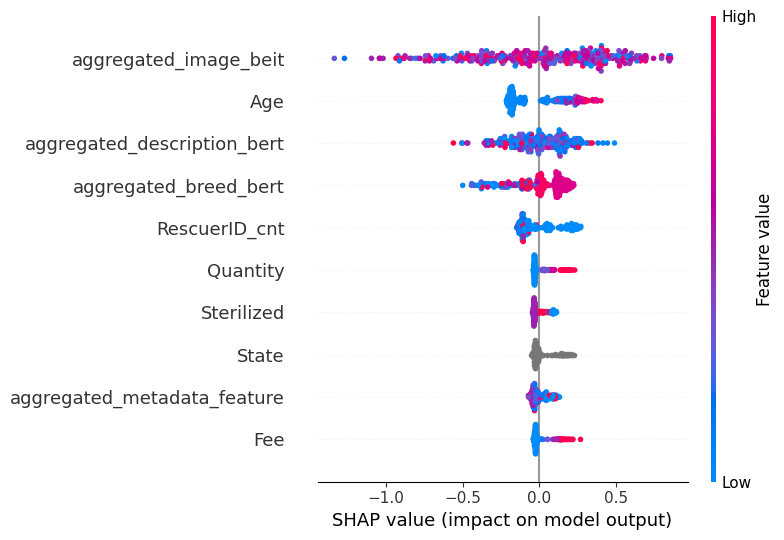

<Figure size 640x480 with 0 Axes>

In [176]:
mean_abs_shap_values = np.abs(shap_values_adjusted).mean(axis=0)
top_10_indices = np.argsort(mean_abs_shap_values)[-10:]

# Select the top ten features and their corresponding SHAP values
top_10_features = X_sample_adjusted.columns[top_10_indices]
top_10_shap_values = shap_values_adjusted[:, top_10_indices]

plt.figure()  # Create a new figure
shap.summary_plot(top_10_shap_values, X_sample_adjusted[top_10_features])

# Save the plot
plt.savefig("summary_plot.png", bbox_inches='tight')  # Save as PNG